In [1]:
import os
import warnings

os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin/'
import torch
import matplotlib.pyplot as plt

from utils import mean_regrets, set_matplotlib_params
import numpy as np

warnings.filterwarnings("ignore")

set_matplotlib_params()

torch.manual_seed(999)
torch.set_default_dtype(torch.double)

In [2]:
pwd = os.getcwd()
resdir = "test"

config = [f for f in os.listdir(f'{pwd}/{resdir}') if f.startswith('config')][0]
f = open(f'{pwd}/{resdir}/{config}', 'r')
content = f.read().split('\n')[:-1]
settings = [[], [], [], [], 0, 0, 0, 0]
for i in range(len(content)):
    equal = content[i].find('=')
    settings[i] = content[i][equal + 1:].split(' ')
    if i > 3:
        settings[i] = int(settings[i][0])
experiments, methods, kernels, acqfs, N_REP, N_INIT, budget, seed = settings
method = methods[0]
reldim = int(settings[0][0].split('_')[1][0])
results = {e: {m: {k: {a: {} for a in acqfs} for k in kernels} for m in methods} for e in experiments}

In [3]:
for exp in experiments:
    for kernel in kernels:
        for acqf in acqfs:
            results[exp][method][kernel][acqf]["regrets"] = []
            results[exp][method][kernel][acqf]["bestvals"] = []
            results[exp][method][kernel][acqf]["costs"] = []
            results[exp][method][kernel][acqf]["train_X"] = []
            results[exp][method][kernel][acqf]["train_Y"] = []
            results[exp][method][kernel][acqf]["train_Y_nonoise"] = []
            results[exp][method][kernel][acqf]["stopped"] = []
            results[exp][method][kernel][acqf]["idx_path"] = []
            results[exp][method][kernel][acqf]["sensitivity_path"] = []
            results[exp][method][kernel][acqf]["ard_path"] = []


files = [f for f in os.listdir(f'{pwd}/{resdir}') if not (f.startswith('.') or f.startswith('config'))]

for file in files:
    exp, scheme, method, kernel, acqf, seed = file[:-3].split('_')
    exp += f"_{scheme}"
    try:
        data = torch.load(f"{pwd}/{resdir}/{file}")
    except Exception:
        continue
    results[exp][method][kernel][acqf]["regrets"].append(data["regrets"])
    results[exp][method][kernel][acqf]["bestvals"].append(data["bestvals"])
    results[exp][method][kernel][acqf]["costs"].append(data["costs"])
    results[exp][method][kernel][acqf]["train_X"].append(data["train_X"])
    results[exp][method][kernel][acqf]["train_Y"].append(data["train_Y"])
    results[exp][method][kernel][acqf]["train_Y_nonoise"].append(data["train_Y_nonoise"])
    results[exp][method][kernel][acqf]["sensitivity_path"].append(data["sensitivity_path"])
    results[exp][method][kernel][acqf]["ard_path"].append(data["ard_path"])
    try:
        results[exp][method][kernel][acqf]["idx_path"].append(data["idx_path"])
    except Exception:
        results[exp][method][kernel][acqf]["idx_path"] = []
    try:
        results[exp][method][kernel][acqf]["stopped"].append(data["stopped"])
    except Exception:
        results[exp][method][kernel][acqf]["stopped"].append(len(data["costs"]))

grid = np.linspace(0, budget * reldim, budget+1)
for exp in experiments:
    reldim = int(exp.split('_')[1][0])
    for kernel in kernels:
        for acqf in acqfs:
            grid = np.linspace(0, budget * reldim, budget+1)
            for metric in ["regrets", "bestvals"]:
                mean, std = mean_regrets(results[exp][method][kernel][acqf], grid, metric)
                results[exp][method][kernel][acqf][f"mean_{metric}"] = mean
                results[exp][method][kernel][acqf][f"std_{metric}"] = std
                results[exp][method][kernel][acqf]["grid"] = grid

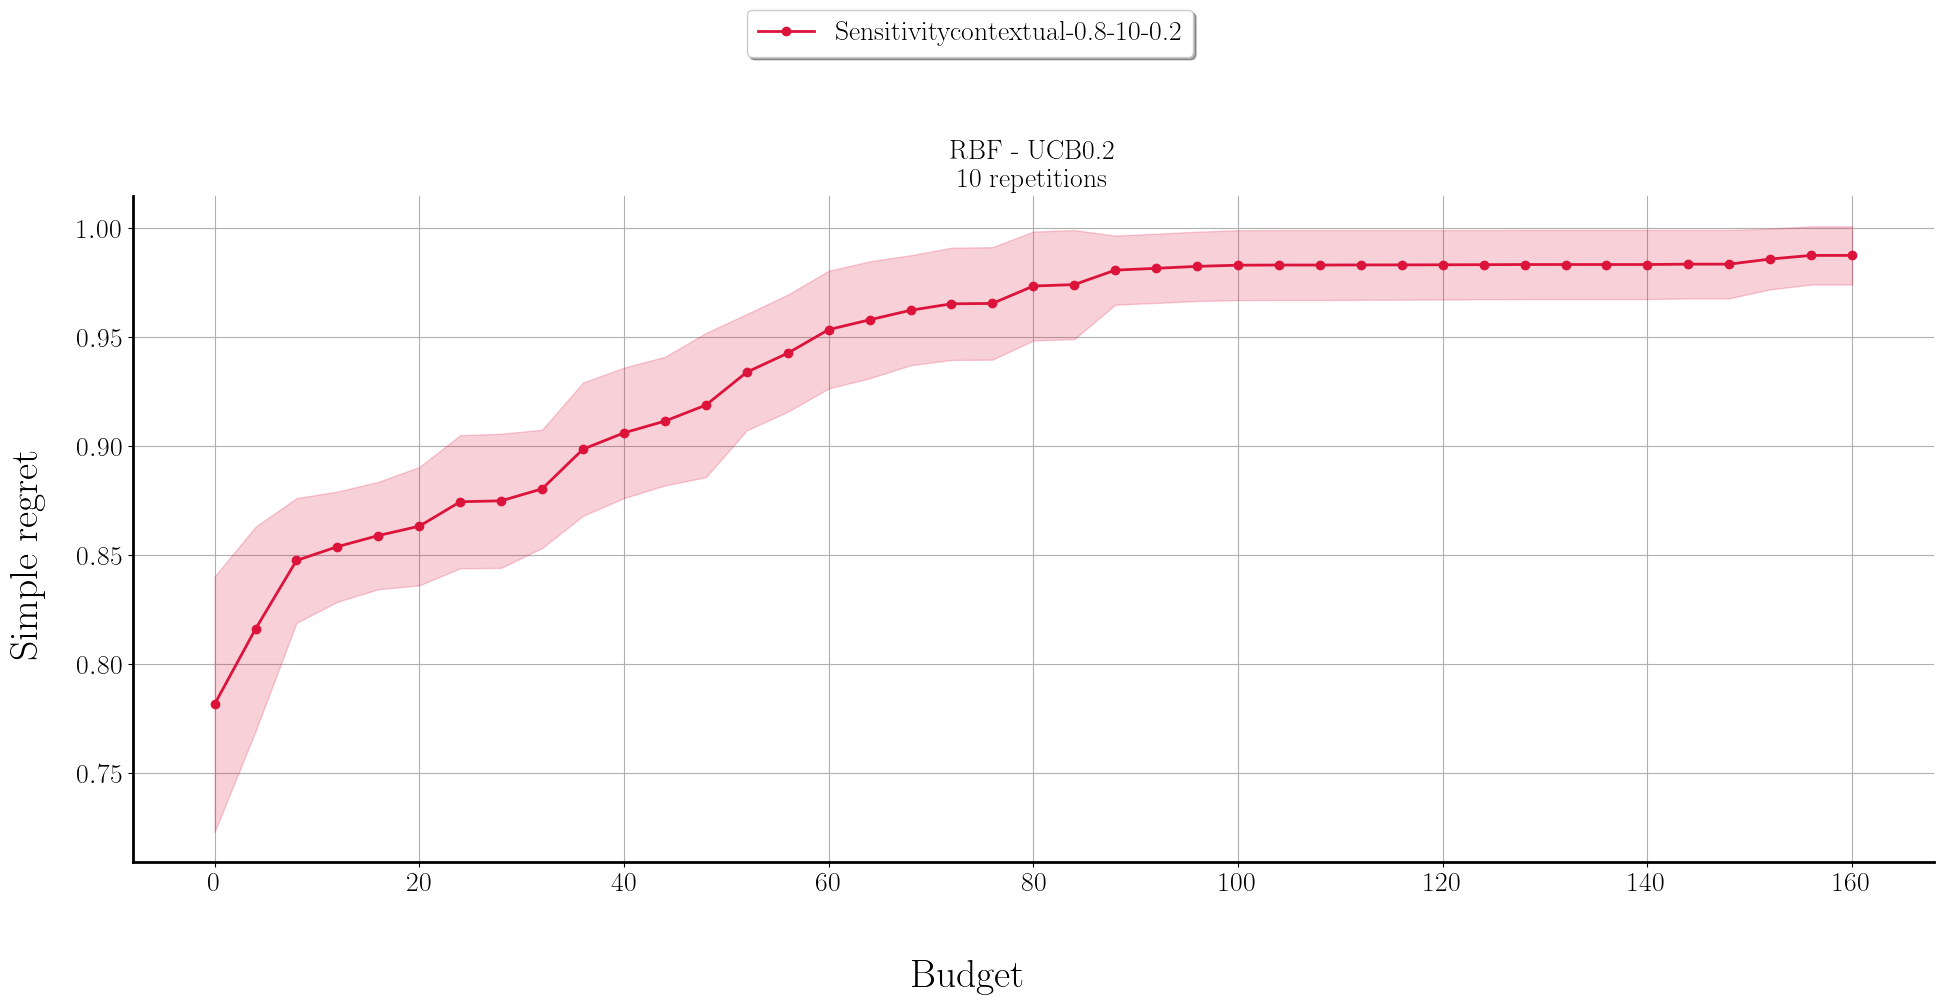

In [4]:
metric = "bestvals"

name, color, marker, zorder = [
  r"\texttt{SADCBO} - Sensitivity Analysis-driven CBO",
  "crimson",
  "o",
  150,
]

fig, axes = plt.subplots(len(experiments), len(acqfs) * len(kernels), figsize=(20,9 * len(experiments)), squeeze=False)
for i, exp in enumerate(experiments):
    for j, kernel in enumerate(kernels):
        for k, acqf in enumerate(acqfs):
            nreps = len(results[exp][method][kernel][acqf]['regrets'])
            plotidx = k if not j else len(acqfs) + k

            mean = results[exp][method][kernel][acqf][f"mean_{metric}"].squeeze()
            std = results[exp][method][kernel][acqf][f"std_{metric}"].squeeze()
            grid = results[exp][method][kernel][acqf]["grid"]
            axes[i, plotidx].plot(grid, mean,
                                  label=f"{method}" if (not i and not j and not k) else None,
                                  color=color, zorder=zorder,
                                  marker='o')
            axes[i, plotidx].fill_between(grid, mean - std, mean + std,
                                alpha=.2, color=color, zorder=zorder)
            axes[i, plotidx].set_title(f'{kernel} - {acqf}' + '\n' + str(nreps) + ' repetitions', fontsize=20)
            axes[i, plotidx].grid()

fig.legend(ncol=len(methods), loc="upper center", shadow=True, bbox_to_anchor=(.5, 1.12))
fig.supxlabel('Budget')
fig.supylabel('Simple regret')
fig.tight_layout()
plt.show()